<a href="https://colab.research.google.com/github/GGpark1/User-Log-data-analytics/blob/main/refactoring_commerce_analytics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Module import

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
#pd.options.display.float_format = "{:,.2f}".format
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime as dt
import warnings
warnings.simplefilter("ignore")

## Basic Preprocessing

In [3]:
df = pd.read_csv('/content/drive/MyDrive/CP2/2019-Oct.csv')

In [4]:
# 지역에 관한 정보가 없으므로 UTC로 시간대로 가정 
# 일자별 분석을 용이하게 하기 위해 dt 포맷을 YYYY-MM-DD 형태로 전처리

df['event_time'] = pd.to_datetime(df['event_time']).dt.tz_convert(None)

In [5]:
# price가 0인 log 데이터의 비율
# 삭제해도 무방할 비율처럼 보임

df.loc[df['price'] == 0].shape[0] / df.shape[0]

0.0016177856203304294

In [6]:
# price가 0인 데이터 drop

df = df.loc[~(df['price'] == 0)]

In [7]:
# category와 brand 모두 null인 데이터의 비율 
# 다소 크지만, 해당 데이터에서 파악할 수 있는 정보가 적으므로 삭제함

df.loc[df['category_code'].isnull() & df['brand'].isnull()].shape[0] / df.shape[0]

0.08748209153208283

In [8]:
# category와 brand 모두 null인 데이터 drop

df = df.loc[~(df['category_code'].isnull() & df['brand'].isnull())]

## EDA

In [9]:
# EDA 관련 함수
# 제품군 별로 살펴보기 위해 전처리 과정을 함수화 함

def make_visit_table(df):
    # 일자별 방문자, 방문세션 카운팅

    elec_daily_summary_table=df.groupby(by=[df['event_time'].dt.normalize()]).agg(
    Number_of_daily_visits=('user_session', lambda x: x.nunique()),
    Number_of_daily_visitors=('user_id', lambda x: x.nunique()))

    return elec_daily_summary_table

def make_categori_table(df, type):
    # 일자별 판매량, 판매액 카운팅
    # df : 집계할 데이터프레임
    # type : 집계할 유저 행동 유형

    sales = df.loc[df['event_type'] == type].groupby(by=[df['event_time'].dt.normalize()]).agg(
    Number_of_unit =('event_type', 'count'),
    unit_price =('price', 'sum')).reset_index()

    return sales

def merge_count_table(daily_table, sales, carts):
    daily_table=pd.merge(left=daily_table,
                          right=sales,
                          left_on=['event_time'],
                          right_on=['event_time'],
                          how='left')

    daily_table=pd.merge(left=daily_table,
                          right=carts,
                          left_on=['event_time'],
                          right_on=['event_time'],
                          how='left')
    
    return daily_table

In [10]:
# 전체 제품군에 대한 방문자, 방문세션 테이블

daily_summary_table = make_visit_table(df)
daily_summary_table.head()

,Number_of_daily_visits,Number_of_daily_visitors
event_time,,
2019-10-01,254214,181404
2019-10-02,246700,176210
2019-10-03,229089,163367
2019-10-04,288557,202227
2019-10-05,264814,187681


In [11]:
# 전체 제품군에 대한 판매량, 판매액 테이블

sales = make_categori_table(df, 'purchase')
sales.rename(columns = {'Number_of_unit' : 'Number_of_daily_sales', 'unit_price':'Total_daily_sales'}, inplace = True)
sales.head()

,event_time,Number_of_daily_sales,Total_daily_sales
0,2019-10-01,18260,6120577.96
1,2019-10-02,18375,6048022.63
2,2019-10-03,18236,6065535.00
3,2019-10-04,25925,8470555.41
4,2019-10-05,22363,7192074.35


In [12]:
carts = make_categori_table(df, 'cart').drop(columns = 'unit_price')
carts.rename(columns = {'Number_of_unit':'Number_of_daily_carts'}, inplace = True)
carts.head()

,event_time,Number_of_daily_carts
0,2019-10-01,16615
1,2019-10-02,17173
2,2019-10-03,19257
3,2019-10-04,43623
4,2019-10-05,35325


In [13]:
daily_summary_table = merge_count_table(daily_summary_table, sales = sales, carts = carts)
daily_summary_table.head()

,event_time,Number_of_daily_visits,Number_of_daily_visitors,Number_of_daily_sales,Total_daily_sales,Number_of_daily_carts
0,2019-10-01,254214,181404,18260,6120577.96,16615
1,2019-10-02,246700,176210,18375,6048022.63,17173
2,2019-10-03,229089,163367,18236,6065535.00,19257
3,2019-10-04,288557,202227,25925,8470555.41,43623
4,2019-10-05,264814,187681,22363,7192074.35,35325


In [14]:
# 피쳐 순서 조정 

daily_summary_table = daily_summary_table[['event_time', 'Number_of_daily_visits', 'Number_of_daily_visitors', 'Number_of_daily_carts', 'Number_of_daily_sales', 'Total_daily_sales']]

In [15]:
# 전환율 테이블 구성

conversion_table = pd.DataFrame({'event_time' : daily_summary_table['event_time']})

conversion_table['Visit-Cart-conversion'] = daily_summary_table['Number_of_daily_carts'] / daily_summary_table['Number_of_daily_visits']
conversion_table['Visit-Sale-conversion'] = daily_summary_table['Number_of_daily_sales'] / daily_summary_table['Number_of_daily_visits']
conversion_table['Cart-Sale-conversion'] = daily_summary_table['Number_of_daily_sales'] / daily_summary_table['Number_of_daily_carts']

In [16]:
conversion_table.head()

,event_time,Visit-Cart-conversion,Visit-Sale-conversion,Cart-Sale-conversion
0,2019-10-01,0.065358,0.071829,1.099007
1,2019-10-02,0.069611,0.074483,1.069994
2,2019-10-03,0.084059,0.079602,0.946980
3,2019-10-04,0.151176,0.089844,0.594297
4,2019-10-05,0.133396,0.084448,0.633064


### 방문 세션 EDA 결과
- 일자별 방문 세션
  - 8~25일의 방문 세션이 평균보다 높음
- 요일별 방문 세션
  - 금요일에 방문 세션이 평균적으로 가장 많음
  - 목요일에 방문 세션이 평균적으로 가장 적음

In [17]:
print('Daily Visits Statistics')
print('-'*50)
print(daily_summary_table['Number_of_daily_visits'].describe())
print('-'*50)
print('Visit Statistics by Dates')
print(daily_summary_table.groupby(by=daily_summary_table['event_time'].dt.day_name()).Number_of_daily_visits.describe())

Daily Visits Statistics
--------------------------------------------------
count        31.000000
mean     284750.516129
std       24692.622364
min      229089.000000
25%      265202.500000
50%      288416.000000
75%      303691.000000
max      323844.000000
Name: Number_of_daily_visits, dtype: float64
--------------------------------------------------
Visit Statistics by Dates
            count       mean           std       min        25%       50%  \
event_time                                                                  
Friday        4.0  305888.50  14018.984473  288557.0  297518.00  308345.5   
Monday        4.0  278990.00  25761.076414  249932.0  261676.25  280039.0   
Saturday      4.0  284032.75  17973.398814  264814.0  272493.25  282694.5   
Sunday        4.0  294600.25  31169.267945  260532.0  272097.00  297012.5   
Thursday      5.0  268620.40  23307.832166  229089.0  267514.00  279038.0   
Tuesday       5.0  285849.60  27677.900450  254214.0  261459.00  291776.0   
Wed

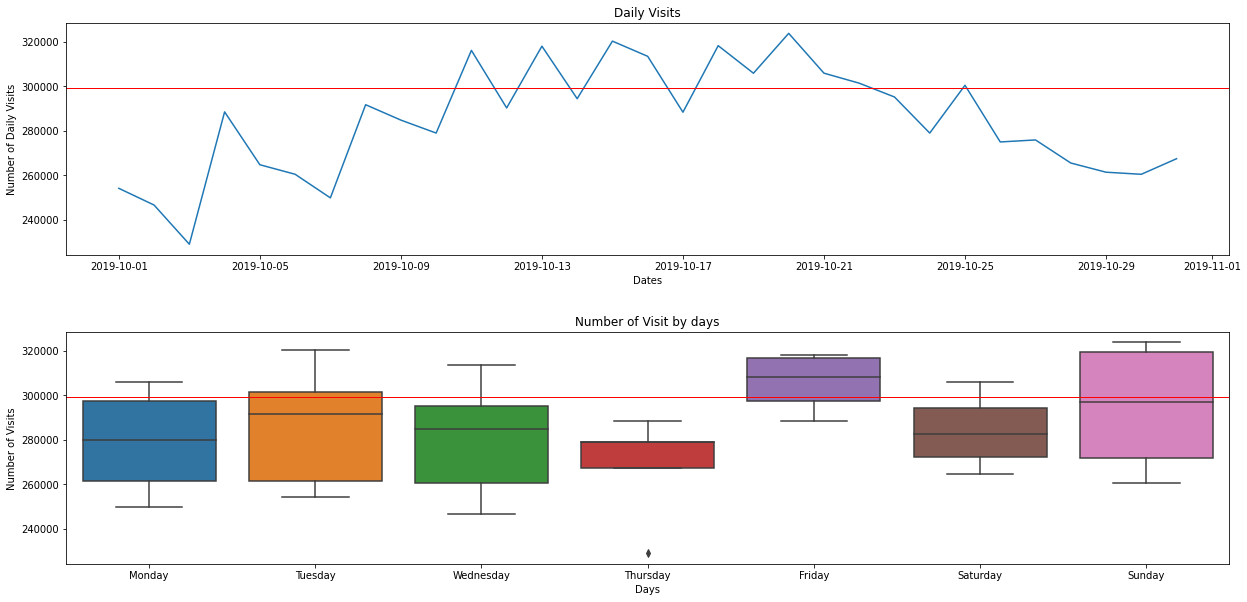

In [18]:
# 일자별 방문 세션

fig=plt.figure(figsize=(18,9))
ax1=fig.add_subplot(2,1,1) # 2x1 형태의 첫 번째 시각화 그래프
sns.lineplot(x='event_time',
              y='Number_of_daily_visits',
              data=daily_summary_table,
             ax=ax1)
plt.axhline(y=299510, color='r', linewidth=1)
plt.title('Daily Visits')
plt.ylabel('Number of Daily Visits')
plt.xlabel('Dates')

# 요일별 방문 세션

ax2=fig.add_subplot(2,1,2)

sns.boxplot(x=daily_summary_table['event_time'].dt.dayofweek, # date를 0, 1, 2, 3, 4, 5, 6 형태로 변환 
            y=daily_summary_table['Number_of_daily_visits'],
            ax=ax2)
plt.axhline(y=299510, color='r', linewidth=1)
plt.title('Number of Visit by days')
plt.ylabel('Number of Visits')
plt.xlabel('Days')
plt.xticks([0,1,2,3,4,5,6], ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])
fig.tight_layout(pad=3.0); # 그래프 패딩 범위 설정

### 판매량 EDA 결과
- 일자별 판매량
  - 2~3일 판매량이 높음 : 해당 요일에 어떤 물건이 많이 팔리는지 확인 필요
  - 10일~19일 판매량 높음 : 해당 요일에 어떤 물건이 많이 팔리는지 확인 필요
- 요일별 판매량
  - 금, 일의 판매량이 높음
  - 화, 목의 판매량이 낮음
  - 요일별로 어떤 물건이 많이 팔리는지 확인 필요

In [19]:
print('Daily Sales Statistics')
print('-'*50)
print(daily_summary_table['Number_of_daily_sales'].describe())
print('-'*50)
print('Sales Statistics by Dates')
print(daily_summary_table.groupby(by=daily_summary_table['event_time'].dt.day_name()).Number_of_daily_sales.describe())

Daily Sales Statistics
--------------------------------------------------
count       31.000000
mean     22724.548387
std       2974.412725
min      18236.000000
25%      20485.500000
50%      22591.000000
75%      24398.000000
max      29919.000000
Name: Number_of_daily_sales, dtype: float64
--------------------------------------------------
Sales Statistics by Dates
            count      mean          std      min      25%      50%       75%  \
event_time                                                                      
Friday        4.0  24441.50  1377.741509  22591.0  24092.5  24625.0  24974.00   
Monday        4.0  22808.75  3419.956956  19927.0  20143.0  22085.0  24750.75   
Saturday      4.0  22811.75  1055.521159  21551.0  22160.0  22908.5  23560.25   
Sunday        4.0  23742.25  2932.846214  21048.0  21928.5  23077.0  24890.75   
Thursday      5.0  21547.80  3501.747878  18236.0  18964.0  20756.0  22840.00   
Tuesday       5.0  21721.20  2996.335045  18260.0  19256.0  21

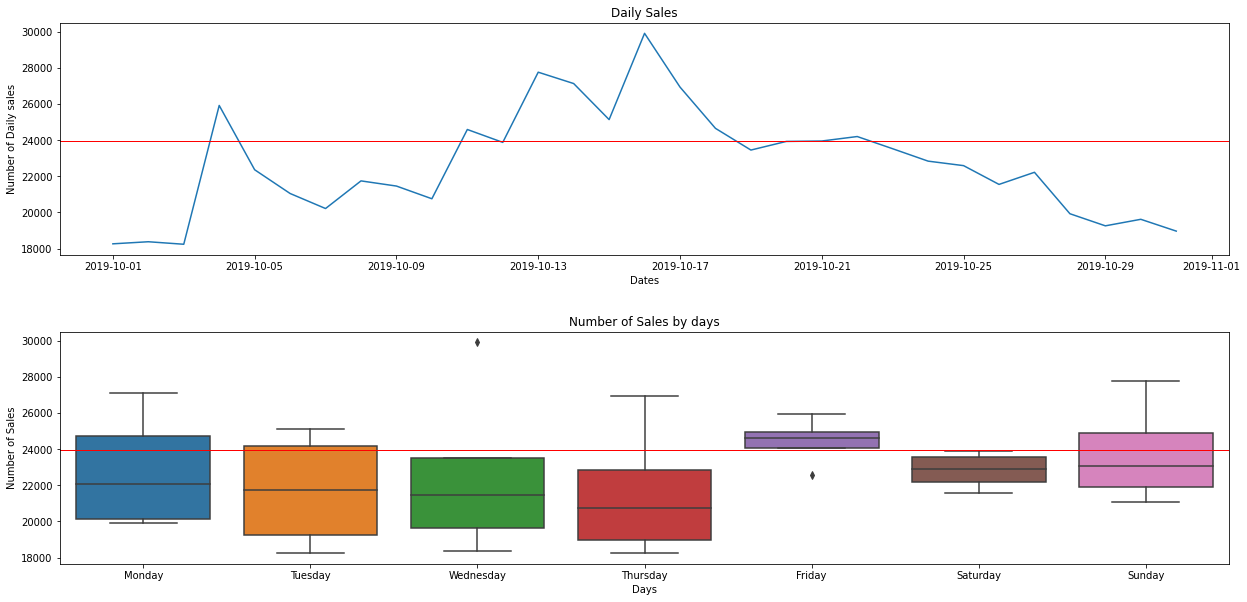

In [20]:
# 일자별 판매량

fig=plt.figure(figsize=(18,9))
ax1=fig.add_subplot(2,1,1) # 2x1 형태의 첫 번째 시각화 그래프
sns.lineplot(x='event_time',
              y='Number_of_daily_sales',
              data=daily_summary_table,
             ax=ax1)
plt.axhline(y=23962, color='r', linewidth=1)
plt.title('Daily Sales')
plt.ylabel('Number of Daily sales')
plt.xlabel('Dates')

# 요일별 판매량

ax2=fig.add_subplot(2,1,2)

sns.boxplot(x=daily_summary_table['event_time'].dt.dayofweek, # date를 0, 1, 2, 3, 4, 5, 6 형태로 변환 
            y=daily_summary_table['Number_of_daily_sales'],
            ax=ax2)
plt.axhline(y=23962, color='r', linewidth=1)
plt.title('Number of Sales by days')
plt.ylabel('Number of Sales')
plt.xlabel('Days')
plt.xticks([0,1,2,3,4,5,6], ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])
fig.tight_layout(pad=3.0); # 그래프 패딩 범위 설정

## Conversion 지표 정의

- Visit-Cart Conversion : 방문 수 대비 카트에 물건을 담은 수의 비율
- Visit-Sale Conversion : 방문 수 대비 물건을 구매한 수의 비율
- Cart-Sale Conversion : 카트에 물건을 담은 수 대비 물건을 구매한 수의 비율


### Visit-Cart Conversion
- 방문 세션과 패턴이 대체로 일치함
- 주말의 Visit-Cart Conversion이 평일보다 평균적으로 높음
- Visit-Cart Conversion은 요일보다 물건에 더 영향을 받을 수 있을 것 같음
- **Event_time을 Product로 대체하여 분석 진행 필요(물건 별 Visit-Cart Conversion)**

In [ ]:
# Visit-Cart Conversion
# Visit-Cart Conversion은 요일보다 물건에 더 영향을 받을 것 같다. 
# event_time을 product로 대체해서 분석 진행

print('Conversion Rates Statistics')
print('-'*50)
print(conversion_table['Visit-Cart-conversion'].describe())
print('-'*50)
print('Visit-Cart-conversion Rates Statistics by Dates')
print('-'*50)
print(conversion_table.groupby(by=conversion_table['event_time'].dt.day_name())['Visit-Cart-conversion'].describe())

Conversion Rates Statistics
--------------------------------------------------
count    31.000000
mean      0.102884
std       0.032837
min       0.062565
25%       0.067631
50%       0.121206
75%       0.125778
max       0.152895
Name: Visit-Cart-conversion, dtype: float64
--------------------------------------------------
Visit-Cart-conversion Rates Statistics by Dates
--------------------------------------------------
            count      mean       std       min       25%       50%       75%  \
event_time                                                                      
Friday        4.0  0.116159  0.035105  0.067467  0.107771  0.122997  0.131386   
Monday        4.0  0.102139  0.039990  0.066934  0.070751  0.095366  0.126754   
Saturday      4.0  0.114225  0.029031  0.071014  0.111276  0.126245  0.129195   
Sunday        4.0  0.111664  0.022715  0.077605  0.111109  0.122615  0.123170   
Thursday      5.0  0.095934  0.034668  0.062565  0.067796  0.084059  0.126768   
Tuesday 

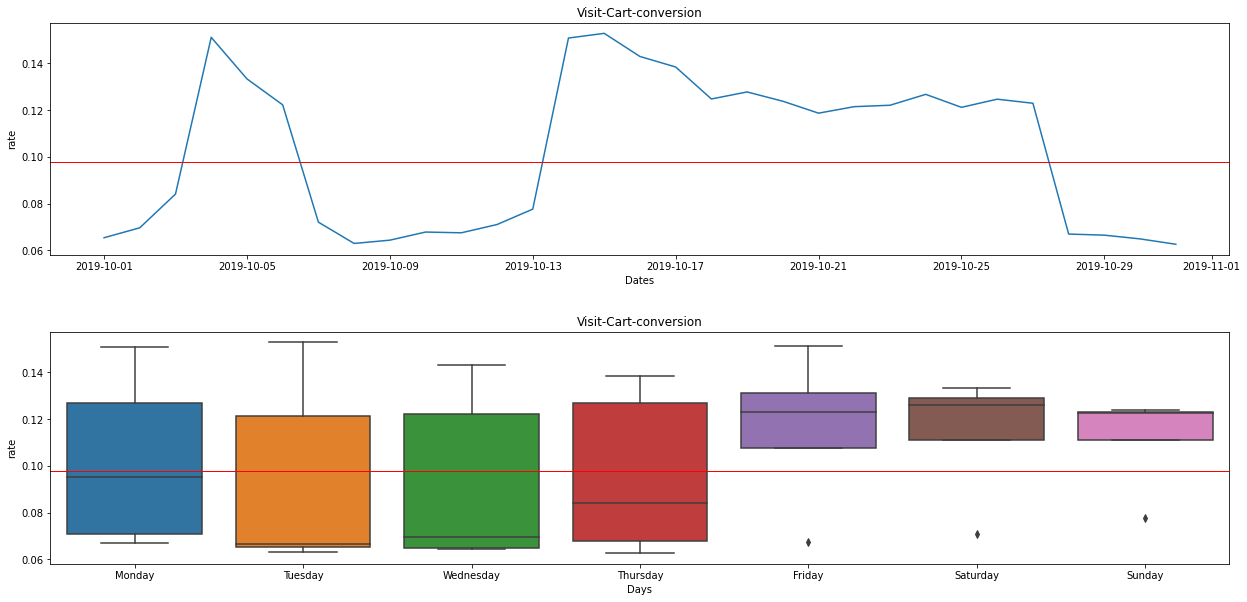

In [ ]:
# 일자별 Visit-Cart Conversion

fig=plt.figure(figsize=(18,9))
ax1=fig.add_subplot(2,1,1) # 2x1 형태의 첫 번째 시각화 그래프
sns.lineplot(x='event_time',
              y='Visit-Cart-conversion',
              data=conversion_table,
             ax=ax1)
plt.axhline(y=0.098, color='r', linewidth=1)
plt.title('Visit-Cart-conversion')
plt.ylabel('rate')
plt.xlabel('Dates')

# 요일별 Visit-Cart Conversion

ax2=fig.add_subplot(2,1,2)

sns.boxplot(x=conversion_table['event_time'].dt.dayofweek, # date를 0, 1, 2, 3, 4, 5, 6 형태로 변환 
            y=conversion_table['Visit-Cart-conversion'],
            ax=ax2)
plt.axhline(y=0.098, color='r', linewidth=1)
plt.title('Visit-Cart-conversion')
plt.ylabel('rate')
plt.xlabel('Days')
plt.xticks([0,1,2,3,4,5,6], ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])
fig.tight_layout(pad=3.0); # 그래프 패딩 범위 설정

## Cart-Sale Conversion
- 방문 세션과 판매량이 가장 많은 요일임에도 금토일의 전환율이 눈에 띄게 낮음
- 반대로, 카트에 물건을 담은 횟수 대비 구매 수는 월~목이 제일 많음
- 주말은 충동 구매할 확률이 높다?

In [ ]:
# Cart-Sale Conversion

print('Cart-Sale Conversion Rates Statistics')
print('-'*50)
print(conversion_table['Cart-Sale-conversion'].describe())
print('-'*50)
print('Cart-Sale Conversion Rates Statistics by Dates')
print('-'*50)
print(conversion_table.groupby(by=conversion_table['event_time'].dt.day_name())['Cart-Sale-conversion'].describe())

Cart-Sale Conversion Rates Statistics
--------------------------------------------------
count    31.000000
mean      0.849838
std       0.251979
min       0.513302
25%       0.630705
50%       0.667373
75%       1.121968
max       1.184681
Name: Cart-Sale-conversion, dtype: float64
--------------------------------------------------
Cart-Sale Conversion Rates Statistics by Dates
--------------------------------------------------
            count      mean       std       min       25%       50%       75%  \
event_time                                                                      
Friday        4.0  0.747040  0.270834  0.594297  0.613754  0.620497  0.753783   
Monday        4.0  0.878561  0.281770  0.610735  0.647363  0.890257  1.121455   
Saturday      4.0  0.754870  0.269260  0.599908  0.621236  0.630705  0.764339   
Sunday        4.0  0.759345  0.245405  0.596823  0.640423  0.657829  0.776752   
Thursday      5.0  0.899491  0.229611  0.645690  0.674570  0.946980  1.097156   


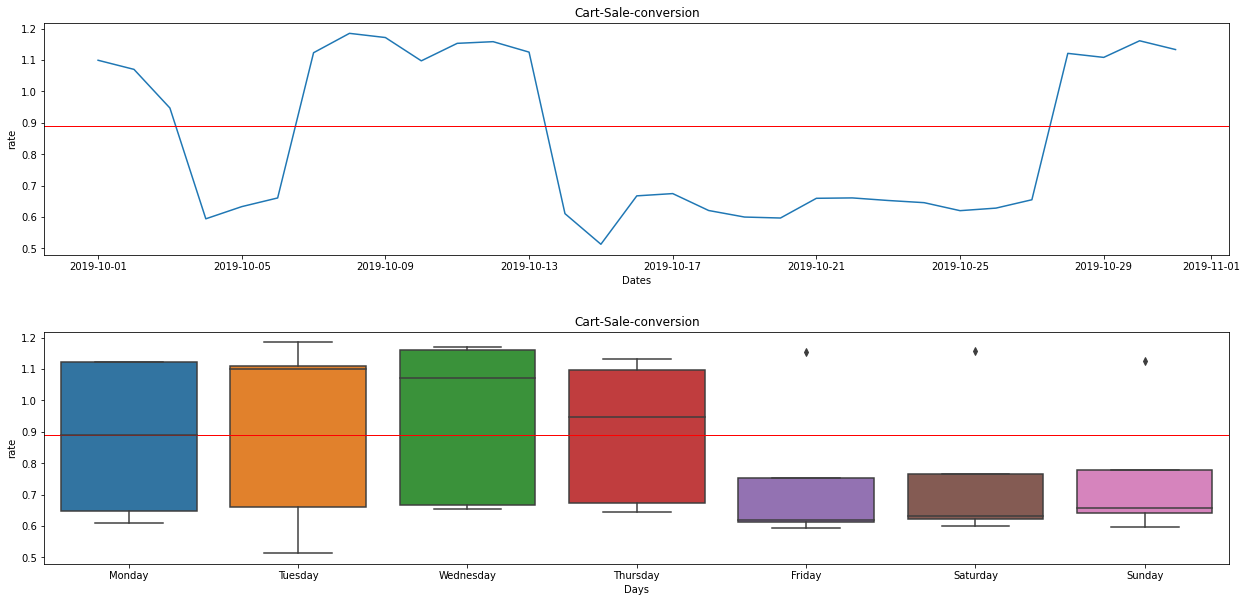

In [ ]:
# Cart-Sales-Conversion
# 금-토-일은 카트에 담지 않고 바로 구매하나?
# 판매량은 금-토-일이 제일 많음
# 카트에 물건을 담은 횟수 대비 구매 수는 월~목이 제일 많음
# 카트에 물건을 담은 사람들은 주말 충동 구매를 하지 않음?

fig=plt.figure(figsize=(18,9))
ax1=fig.add_subplot(2,1,1) # 2x1 형태의 첫 번째 시각화 그래프
sns.lineplot(x='event_time',
              y='Cart-Sale-conversion',
              data=conversion_table,
             ax=ax1)
plt.axhline(y=0.89, color='r', linewidth=1)
plt.title('Cart-Sale-conversion')
plt.ylabel('rate')
plt.xlabel('Dates')

# 요일별 판매량

ax2=fig.add_subplot(2,1,2)

sns.boxplot(x=conversion_table['event_time'].dt.dayofweek, # date를 0, 1, 2, 3, 4, 5, 6 형태로 변환 
            y=conversion_table['Cart-Sale-conversion'],
            ax=ax2)
plt.axhline(y=0.89, color='r', linewidth=1)
plt.title('Cart-Sale-conversion')
plt.ylabel('rate')
plt.xlabel('Days')
plt.xticks([0,1,2,3,4,5,6], ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])
fig.tight_layout(pad=3.0); # 그래프 패딩 범위 설정

## Visit-Sale Conversion
- 월, 토, 일이 방문-구매 conversion이 비교적 높음
- 금요일은 방문수를 생각했을 때 구매율이 다소 저조한 편임
- 방문율 1위는 금요일이지만, Conversion은 평일과 비슷함
- 물건을 판매할 수 있는 기회를 놓치고 있다?
- 4\~5일과 13\~17일 경의 전환율이 다른 날보다 높음 : 해당 요일에 주로 구매하는 상품은 무엇일까?

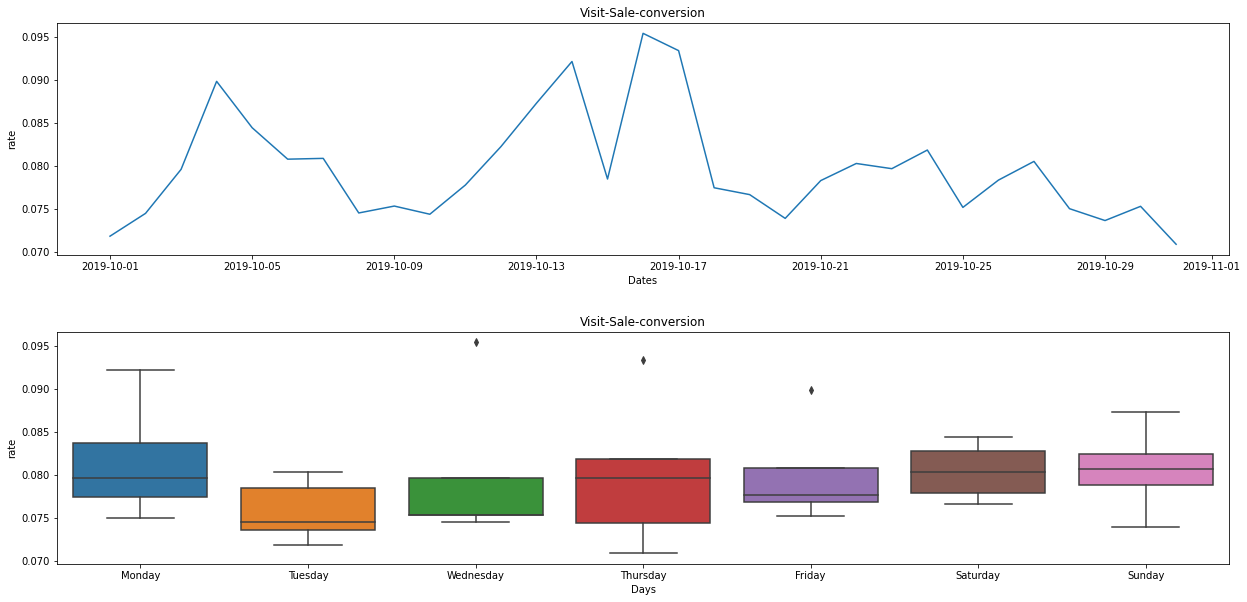

In [ ]:
# 통상적인 임금일 전후로 Conversion이 높음
# 월, 토, 일이 방문-구매 conversion이 비교적 높음 
# 금요일은 방문수를 생각했을 때 구매율이 다소 저조한 편임(방문율 1위는 금 but Conversion은 평일과 비슷함)
# 물건을 판매할 수 있는 기회를 놓치고 있다?

fig=plt.figure(figsize=(18,9))
ax1=fig.add_subplot(2,1,1) # 2x1 형태의 첫 번째 시각화 그래프
sns.lineplot(x='event_time',
              y='Visit-Sale-conversion',
              data=conversion_table,
             ax=ax1)
#plt.axhline(y=0.89, color='r', linewidth=1)
plt.title('Visit-Sale-conversion')
plt.ylabel('rate')
plt.xlabel('Dates')

ax2=fig.add_subplot(2,1,2)

sns.boxplot(x=conversion_table['event_time'].dt.dayofweek, # date를 0, 1, 2, 3, 4, 5, 6 형태로 변환 
            y=conversion_table['Visit-Sale-conversion'],
            ax=ax2)
#plt.axhline(y=0.89, color='r', linewidth=1)
plt.title('Visit-Sale-conversion')
plt.ylabel('rate')
plt.xlabel('Days')
plt.xticks([0,1,2,3,4,5,6], ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])
fig.tight_layout(pad=3.0); # 그래프 패딩 범위 설정

In [ ]:
conversion_table['event_time'] = conversion_table['event_time'].dt.dayofweek

In [ ]:
# 금요일 이상치 제거

conversion_table_filtered = conversion_table.drop(3)
conversion_table_filtered

,event_time,Visit-Cart-conversion,Visit-Sale-conversion,Cart-Sale-conversion
0,1,0.065358,0.071829,1.099007
1,2,0.069611,0.074483,1.069994
2,3,0.084059,0.079602,0.946980
4,5,0.133396,0.084448,0.633064
5,6,0.122277,0.080789,0.660703
6,0,0.072024,0.080882,1.122993
7,1,0.062911,0.074530,1.184681
8,2,0.064314,0.075333,1.171333
9,3,0.067796,0.074382,1.097156
10,4,0.067467,0.077780,1.152869


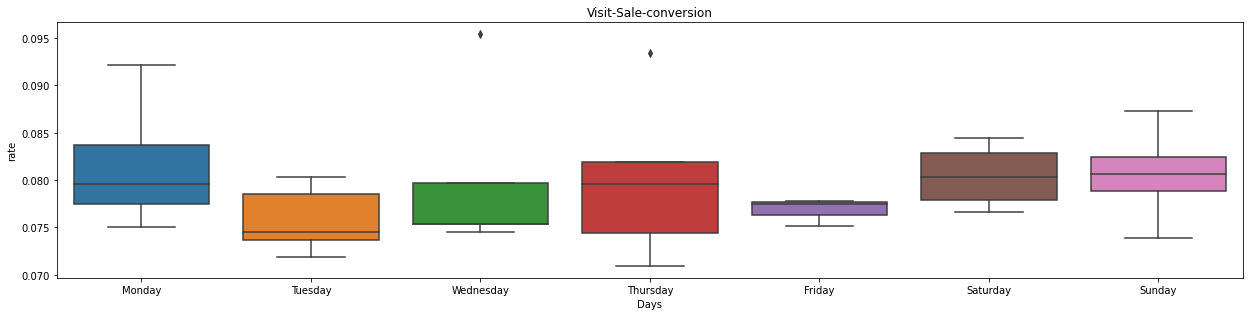

In [ ]:
fig=plt.figure(figsize=(18,9))
ax2=fig.add_subplot(2,1,1)
sns.boxplot(x=conversion_table_filtered['event_time'], # date를 0, 1, 2, 3, 4, 5, 6 형태로 변환 
            y=conversion_table_filtered['Visit-Sale-conversion'],
            ax=ax2)
#plt.axhline(y=0.89, color='r', linewidth=1)
plt.title('Visit-Sale-conversion')
plt.ylabel('rate')
plt.xlabel('Days')
plt.xticks([0,1,2,3,4,5,6], ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])
fig.tight_layout(pad=3.0); # 그래프 패딩 범위 설정

## EDA - 제품별

In [6]:
# EDA 관련 함수 모음

def make_categori_df(df_full, categori):
    # 대분류 카테고리별 df 만드는 함수

    df_cate = df_full.loc[df_full['categori_code_level_1'] == categori]
    df_cate['categori_code_level_2'] = df_cate['category_code'].str.split(".", expand=True)[1]
    return df_cate

def make_product_conversion(df_temp):
    # 제품 별 Conversion 테이블 만드는 함수
    # Groupby and Pivot
    df_cate_action = df_temp.groupby(['categori_code_level_2', 'event_type']).size().to_frame().reset_index()
    df_cate_action = pd.pivot_table(df_cate_action, index = ['categori_code_level_2'], columns = ['event_type'], values = 0).reset_index()

    # Conversion 계산
    df_cate_action['total'] = df_cate_action['cart'] + df_cate_action['purchase'] + df_cate_action['view']
    df_cate_action['view_purchase_con'] = df_cate_action['purchase'] / df_cate_action['view']
    df_cate_action['view_cart_con'] = df_cate_action['cart'] / df_cate_action['view']
    df_cate_action['cart_purchase_con'] = df_cate_action['purchase'] / df_cate_action['cart']
    
    return df_cate_action



In [7]:
# 대분류 칼럼 생성

df["categori_code_level_1"] = df["category_code"].str.split(".", expand=True)[0]
df.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,categori_code_level_1
0,2019-10-01 00:00:00,view,44600062,2103807459595387724,NaN,shiseido,35.79,541312140,72d76fde-8bb3-4e00-8c23-a032dfed738c,NaN
1,2019-10-01 00:00:00,view,3900821,2053013552326770905,appliances.environment.water_heater,aqua,33.20,554748717,9333dfbd-b87a-4708-9857-6336556b0fcc,appliances
2,2019-10-01 00:00:01,view,17200506,2053013559792632471,furniture.living_room.sofa,NaN,543.10,519107250,566511c2-e2e3-422b-b695-cf8e6e792ca8,furniture
3,2019-10-01 00:00:01,view,1307067,2053013558920217191,computers.notebook,lenovo,251.74,550050854,7c90fc70-0e80-4590-96f3-13c02c18c713,computers
4,2019-10-01 00:00:04,view,1004237,2053013555631882655,electronics.smartphone,apple,1081.98,535871217,c6bd7419-2748-4c56-95b4-8cec9ff8b80d,electronics


In [ ]:
# 대분류 아이템의 비율 확인

rate_categori = df.categori_code_level_1.value_counts(normalize=True)
categori_list = df.categori_code_level_1.unique()

print(rate_categori)

electronics     0.557926
appliances      0.171733
computers       0.080319
apparel         0.053194
furniture       0.042979
auto            0.035031
construction    0.025260
kids            0.017986
accessories     0.008215
sport           0.006099
medicine        0.000512
country_yard    0.000487
stationery      0.000261
Name: categori_code_level_1, dtype: float64


In [ ]:
categori_list[1:]

array(['appliances', 'furniture', 'computers', 'electronics', 'apparel',
       'construction', 'auto', 'kids', 'sport', 'accessories', 'medicine',
       'stationery', 'country_yard'], dtype=object)

In [52]:
df_elec = make_categori_df(df, 'electronics')
df_appli = make_categori_df(df, 'appliances')
df_com = make_categori_df(df, 'computers')
df_apparel = make_categori_df(df, 'apparel')
df_furniture = make_categori_df(df, 'furniture')
df_auto = make_categori_df(df, 'auto') # 동력관련 제품

In [53]:
df_appli

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,categori_code_level_1,categori_code_level_2
1,2019-10-01 00:00:00,view,3900821,2053013552326770905,appliances.environment.water_heater,aqua,33.20,554748717,9333dfbd-b87a-4708-9857-6336556b0fcc,appliances,environment
10,2019-10-01 00:00:11,view,2900536,2053013554776244595,appliances.kitchen.microwave,elenberg,51.46,555158050,b5bdd0b3-4ca2-4c55-939e-9ce44bb50abd,appliances,kitchen
12,2019-10-01 00:00:13,view,3900746,2053013552326770905,appliances.environment.water_heater,haier,102.38,555444559,98b88fa0-d8fa-4b9d-8a71-3dd403afab85,appliances,environment
17,2019-10-01 00:00:18,view,10900029,2053013555069845885,appliances.kitchen.mixer,bosch,58.95,519528062,901b9e3c-3f8f-4147-a442-c25d5c5ed332,appliances,kitchen
24,2019-10-01 00:00:23,view,6200260,2053013552293216471,appliances.environment.air_heater,midea,47.62,538645907,7d9a8784-7b6c-426e-9924-9f688812fd71,appliances,environment
...,...,...,...,...,...,...,...,...,...,...,...
42448634,2019-10-31 23:59:04,view,3601530,2053013563810775923,appliances.kitchen.washer,lg,712.87,518085591,3bfb58cd-7892-48cc-8020-2f17e6de6e7f,appliances,kitchen
42448639,2019-10-31 23:59:09,view,4600658,2053013563944993659,appliances.kitchen.dishwasher,samsung,411.83,526595547,aab33a9a-29c3-4d50-84c1-8a2bc9256104,appliances,kitchen
42448675,2019-10-31 23:59:23,view,3901090,2053013552326770905,appliances.environment.water_heater,oasis,25.48,513200477,742aba02-727b-4d15-9222-6484ac846173,appliances,environment
42448697,2019-10-31 23:59:31,view,2800395,2053013563835941749,appliances.kitchen.refrigerators,atlant,282.88,539701280,a9e5a322-c765-d52d-b382-07af17908468,appliances,kitchen


In [54]:
df_elec['event_time'] = df_elec['event_time'].dt.dayofweek
df_appli['event_time'] = df_appli['event_time'].dt.dayofweek
df_com['event_time'] = df_com['event_time'].dt.dayofweek

In [55]:
df_elec = df_elec.loc[df_elec['event_time'] == 4]
df_appli = df_appli.loc[df_appli['event_time'] == 4]
df_com = df_com.loc[df_com['event_time'] == 4]

In [56]:
df_appli

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,categori_code_level_1,categori_code_level_2
3562881,4,view,6302199,2053013554834964853,appliances.kitchen.kettle,redmond,48.88,519023753,3c9b5a9e-d81d-4680-b1bd-a6f3c33883de,appliances,kitchen
3562884,4,view,4600678,2053013563944993659,appliances.kitchen.dishwasher,electrolux,350.05,516600259,14189517-a35c-44cc-aab5-2546def525fa,appliances,kitchen
3562893,4,view,3800401,2053013566176363511,appliances.iron,polaris,20.31,514044085,c01cceed-041f-4c57-9fa3-0c9b9d801633,appliances,iron
3562905,4,view,6301723,2053013554834964853,appliances.kitchen.kettle,polaris,77.14,522471309,651c83f6-1f67-4278-8d79-7ca3cd209e29,appliances,kitchen
3562912,4,view,3100034,2053013555262783879,appliances.kitchen.blender,braun,54.03,513046388,a7b76518-92af-4ace-a337-618a3b6df70d,appliances,kitchen
...,...,...,...,...,...,...,...,...,...,...,...
34768470,4,view,10900168,2053013555069845885,appliances.kitchen.mixer,kitfort,118.12,564212349,1fdc1d22-e85b-43c3-8d52-12e8ddfc2249,appliances,kitchen
34768476,4,view,10900168,2053013555069845885,appliances.kitchen.mixer,kitfort,118.12,564212349,1fdc1d22-e85b-43c3-8d52-12e8ddfc2249,appliances,kitchen
34768490,4,view,2702331,2053013563911439225,appliances.kitchen.refrigerators,lg,527.65,558035852,e4bed017-d26a-4d8a-bd3e-d8a6747aed14,appliances,kitchen
34768497,4,view,3601514,2053013563810775923,appliances.kitchen.washer,samsung,437.33,563901481,45ae6881-bf44-4552-9818-34f28a2c8201,appliances,kitchen


### Electronic 분석

In [20]:
# 전자제품 중 세부 카테고리의 비율

df_elec['categori_code_level_2'].value_counts(normalize=True)

smartphone    0.712643
audio         0.099086
clocks        0.079383
video         0.071556
tablet        0.019556
telephone     0.014844
camera        0.002932
Name: categori_code_level_2, dtype: float64

In [21]:
# 고민
# 어떤 건 카트에 담기 보다 바로 구매한다고 해석하고,
# 어떤 건 카트에 담으면 구매할 확률이 높다고 해석한다.
# 같은 지표인데 이렇게 해석이 달라도 될까?

In [22]:
# electorinic Conversion
# 카메라는 보고(view) 카드에 담는 확률은 낮지만(0.01), 카드에 담으면 구매확률이 매우 높아짐(0.92)
# 가격은 스마트폰이 더 비싼데, 카트에 담지 않고 구매하는 비율은 더 높음 -> 브랜드 수의 차이 때문일까? -> 지배적인 브랜드가 있으면 별로 고민하지 않고 그 브랜드를 살 것
# 시계 브랜드도 압도적인 시장이 있는데 카트 비율이 높다 -> 스마트워치에 대한 필요성, 효용성에 대한 설득이 다른 전자기기에 비해 아직 덜 된 편
# 스마트워치는 주로 스마트폰의 브랜드에 맞춰 구매함 -> 애플 워치의 비율이 높음 -> 그렇다면, 고민하지 않고 바로 구매할 수 있도록 판촉해야 하지 않을까? -> 효용성에 대한 제시
# 브랜드 담당자가 아니기 때문에 브랜드 분석까지는 안해도 될 것 같음

df_elec_conv = make_product_conversion(df_elec)
df_elec_conv.sort_values('view_purchase_con')

event_type,categori_code_level_2,cart,purchase,view,total,view_purchase_con,view_cart_con,cart_purchase_con
1,camera,86,71,6268,6425,0.011327,0.013720,0.825581
2,clocks,3455,2470,168047,173972,0.014698,0.020560,0.714906
5,telephone,742,487,31303,32532,0.015558,0.023704,0.656334
4,tablet,1387,809,40663,42859,0.019895,0.034110,0.583273
6,video,5820,3050,147950,156820,0.020615,0.039338,0.524055
0,audio,8291,5078,203784,217153,0.024919,0.040685,0.612471
3,smartphone,82759,45991,1433050,1561800,0.032093,0.057750,0.555722


In [23]:
df_elec_unique = df_elec.drop_duplicates('product_id')
df_elec_unique.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,categori_code_level_1,categori_code_level_2
3562877,4,view,1004536,2053013555631882655,electronics.smartphone,huawei,796.64,530393296,ad731471-2f54-4692-ab01-48d06f8e8f02,electronics,smartphone
3562880,4,view,1004856,2053013555631882655,electronics.smartphone,samsung,130.76,556452834,5c1459a7-d7cf-4b21-a19d-3369e3a28f49,electronics,smartphone
3562886,4,purchase,1004767,2053013555631882655,electronics.smartphone,samsung,252.88,512365334,86c75faf-df96-452e-a402-18cd2b02d8ca,electronics,smartphone
3562889,4,view,21400929,2053013561579406073,electronics.clocks,casio,45.82,537861189,df89e02b-d50a-4962-8f19-fbc95d15b6ac,electronics,clocks
3562892,4,cart,1002633,2053013555631882655,electronics.smartphone,apple,358.57,556546486,d30d6845-baf2-4e7e-982e-c48089dd9c0d,electronics,smartphone


In [24]:
# 가격에 대한 기초 통계

df_elec.groupby(['categori_code_level_2', 'event_type']).price.describe().reset_index()

,categori_code_level_2,event_type,count,mean,std,min,25%,50%,75%,max
0,audio,cart,8291.0,117.255574,68.981589,1.00,40.9000,159.910,161.840,1214.06
1,audio,purchase,5078.0,118.465191,76.715357,0.88,43.0525,159.910,161.840,1296.04
2,audio,view,203784.0,120.795313,180.373739,0.00,33.4300,82.700,160.880,2573.81
3,camera,cart,86.0,363.785465,157.012747,61.52,205.7350,437.410,463.050,898.12
4,camera,purchase,71.0,536.840986,436.970340,25.62,300.0350,411.340,497.885,2316.40
5,camera,view,6268.0,485.811958,531.467476,0.00,138.2200,353.915,527.400,2567.01
6,clocks,cart,3455.0,328.827939,184.584198,0.00,179.9000,319.340,444.995,1878.55
7,clocks,purchase,2470.0,275.112773,227.778043,9.46,75.9100,292.640,417.910,2522.59
8,clocks,view,168047.0,291.351617,385.662304,0.00,67.7700,175.040,350.070,2574.07
9,smartphone,cart,82759.0,432.383919,396.271240,0.00,170.6000,250.430,581.160,2110.45


In [25]:
# 판매비율 상위 5개 브랜드

df_smartphone_rate = df_elec['brand'].loc[(df_elec['categori_code_level_2'] == 'smartphone') & (df_elec['event_type'] == 'purchase')].value_counts(normalize=True).round(3).to_frame()
df_smartphone_rate.head()

,brand
samsung,0.426
apple,0.339
xiaomi,0.115
huawei,0.063
oppo,0.034


In [26]:
# 판매비율 상위 5개 브랜드의 가격에 대한 기술통계
# 가격 분포가 고를 수록 Cart에 담고 심사숙고할 가능성이 높을까?

df_elec_unique.loc[df_elec_unique['categori_code_level_2'] == 'smartphone'].groupby(['brand']).price.describe().reset_index().sort_values('mean', ascending = False).head()

,brand,count,mean,std,min,25%,50%,75%,max
0,apple,152.0,1023.118816,421.748338,358.57,727.450,975.570,1282.520,2072.10
8,google,9.0,789.240000,171.711968,555.97,604.910,849.490,885.210,1055.11
25,oneplus,19.0,661.793684,144.241123,450.20,566.025,646.310,779.735,874.67
34,umi,2.0,617.750000,218.411143,463.31,540.530,617.750,694.970,772.19
29,samsung,158.0,525.667468,354.125263,77.14,229.075,387.105,746.480,1544.42


In [27]:
df_camera_rate = df_elec['brand'].loc[(df_elec['categori_code_level_2'] == 'camera') & (df_elec['event_type'] == 'purchase')].value_counts(normalize=True).round(3).to_frame()
df_camera_rate.head()

,brand
gopro,0.254
canon,0.239
sony,0.239
panasonic,0.056
sjcam,0.042


In [28]:
# Camera 브랜드의 평균&최고가 제품의 가격 차이는 스마트폰 보다 적다

df_elec_unique.loc[df_elec_unique['categori_code_level_2'] == 'camera'].groupby(['brand']).price.describe().reset_index().sort_values('mean', ascending = False).head()

,brand,count,mean,std,min,25%,50%,75%,max
2,canon,94.0,1009.103830,557.290011,117.01,561.9125,912.685,1335.235,2567.01
9,panasonic,17.0,1008.066471,651.920270,218.51,681.7200,875.160,1090.750,2470.05
7,nikon,43.0,944.446744,666.097273,117.01,418.6250,736.330,1385.400,2559.65
8,olympus,3.0,938.150000,553.496675,616.92,618.5900,620.260,1098.765,1577.27
13,sony,55.0,852.968727,586.517400,205.41,406.3200,692.420,1116.580,2316.40


In [29]:
df_clock_rate = df_elec['brand'].loc[(df_elec['categori_code_level_2'] == 'clocks') & (df_elec['event_type'] == 'purchase')].value_counts(normalize=True).round(3).to_frame()
df_clock_rate.head()

,brand
apple,0.440
samsung,0.163
casio,0.147
xiaomi,0.071
wonlex,0.032


In [30]:
filter = df_elec_unique['categori_code_level_2']
filter_2 = df_elec_unique['brand']

df_elec_unique.loc[(filter == 'clocks') & ((filter_2 == 'apple') | (filter_2 == 'samsung') | (filter_2 == 'casio'))].groupby(['brand']).price.describe().reset_index().sort_values('min', ascending = False)

,brand,count,mean,std,min,25%,50%,75%,max
0,apple,44.0,517.904318,197.713335,257.38,404.635,463.335,593.76,1181.50
2,samsung,22.0,300.183636,88.331387,150.95,258.030,308.860,360.34,411.83
1,casio,1453.0,145.862801,193.257802,12.36,45.820,84.430,158.31,2075.73


In [31]:
# 생활용품은 카트에 담기보다 바로 구매하는 경우가 많음(카트에 잘 담지 않음)

df_appli_conv = make_product_conversion(df_appli)
df_appli_conv.sort_values('view_purchase_con', ascending=False)

KeyError: ignored

In [ ]:
# 컴퓨터(용품)은 카트에 담기보다 바로 구매하는 경우가 많음
# view 대비 구매 비율은 다소 낮음 

df_com_conv = make_product_conversion(df_com)
df_com_conv.sort_values('view_purchase_con', ascending=False)

In [ ]:
# NaN 값이 뜨는 이유 -> 카트에 담지 않기 때문
# 의류 분야에서는 신발 판매량이 가장 높음 -> 신발 중심의 마케팅
# 다른 세분류는 크게 의미 없는 판매량임

df_apparel_conv = make_product_conversion(df_apparel)
df_apparel_conv.sort_values('view_purchase_con', ascending=False)

In [ ]:
# 카트에 잘 담지 않음 -> 즉흥적으로 구매? -> 즉흥 구매를 유도할만한 이벤트가 무엇이 있을까?
# 싸서 즉흥 구매하는 것일까? -> 평균 가격, 가격 분포(편차) 확인 필요

df_furniture_conv = make_product_conversion(df_furniture)
df_furniture_conv.sort_values('view_purchase_con', ascending=False)

## 구매가 이뤄지는 제품의 평균 가격과 편차

In [ ]:
df_appli.groupby(['categori_code_level_2', 'event_type']).price.describe().reset_index()

In [ ]:
df_com.groupby(['categori_code_level_2', 'event_type']).price.describe().reset_index()

In [ ]:
# 구매가 이뤄지는 제품의 평균 가격과 편차
# 보기만 하는 제품의 평균 가격과 편차

df_furniture.groupby(['categori_code_level_2', 'event_type']).price.describe().reset_index()

## 일자별 - 요일 방문 추이 시각화(상품별)

In [ ]:
def make_categori_df(df_full, categori):
    # 대분류 카테고리별 df 만드는 함수

    df_cate = df_full.loc[df_full['categori_code_level_1'] == categori]
    df_cate['categori_code_level_2'] = df_cate['category_code'].str.split(".", expand=True)[1]
    return df_cate

In [35]:
elec_daily_summary_table = make_visit_table(df_elec).reset_index()
appli_daily_summary_table = make_visit_table(df_appli).reset_index()
com_daily_summary_table = make_visit_table(df_com).reset_index()
apparel_daily_summary_table = make_visit_table(df_apparel).reset_index()
furniture_daily_summary_table = make_visit_table(df_furniture).reset_index()

AttributeError: ignored

In [ ]:
# 방문 수 시각화 함수

def visits_visualization(daily_table, name):
    print(f'{name} : Daily Visits Statistics')
    print('-'*50)
    print(daily_table['Number_of_daily_visits'].describe())
    print('-'*50)
    print(f'{name} : Visit Statistics by Dates')
    print(daily_table.groupby(by=daily_table['event_time'].dt.day_name()).Number_of_daily_visits.describe())

    # 일자별 방문 세션

    fig=plt.figure(figsize=(18,9))
    ax1=fig.add_subplot(2,1,1) # 2x1 형태의 첫 번째 시각화 그래프
    sns.lineplot(x='event_time',
              y='Number_of_daily_visits',
              data=daily_table,
             ax=ax1)
    #plt.axhline(y=299510, color='r', linewidth=1)
    plt.title(f'{name} : Daily Visits')
    plt.ylabel('Number of Daily Visits')
    plt.xlabel('Dates')

    # 요일별 방문 세션

    ax2=fig.add_subplot(2,1,2)

    sns.boxplot(x=daily_table['event_time'].dt.dayofweek, # date를 0, 1, 2, 3, 4, 5, 6 형태로 변환 
            y=daily_table['Number_of_daily_visits'],
            ax=ax2)
    #plt.axhline(y=299510, color='r', linewidth=1)
    plt.title(f'{name} : Number of Visit by days')
    plt.ylabel('Number of Visits')
    plt.xlabel('Days')
    plt.xticks([0,1,2,3,4,5,6], ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])
    fig.tight_layout(pad=3.0); # 그래프 패딩 범위 설정

In [ ]:
visits_visualization(elec_daily_summary_table, 'Elec')

In [ ]:
visits_visualization(appli_daily_summary_table, 'Appliance')

In [ ]:
visits_visualization(com_daily_summary_table, 'Computers')

In [ ]:
visits_visualization(apparel_daily_summary_table, 'Apparel')

In [ ]:
visits_visualization(furniture_daily_summary_table, 'Furniture')

## 요일별-일자별 판매량(제품별)

In [32]:
def make_sale_table(df_product, daily_table):
    sales = df_product.loc[df_product['event_type'] == 'purchase'].groupby(by=[df_product['event_time'].dt.normalize()]).agg(
    Number_of_daily_sales=('event_type', 'count'),
    Total_daily_sales=('price', 'sum')).reset_index()
    
    carts = df_product.loc[df['event_type'] == 'cart'].groupby(by=[df_product['event_time'].dt.normalize()]).agg(
    Number_of_daily_carts=('event_type', 'count')).reset_index()


    daily_table=pd.merge(left=daily_table,
                          right=sales,
                          left_on=['event_time'],
                          right_on=['event_time'],
                          how='left')

    daily_table=pd.merge(left=daily_table,
                          right=carts,
                          left_on=['event_time'],
                          right_on=['event_time'],
                          how='left')
    
    return daily_table

In [33]:
def sales_visualization(daily_table):

    # 일자별 판매량

    fig=plt.figure(figsize=(18,9))
    ax1=fig.add_subplot(2,1,1) # 2x1 형태의 첫 번째 시각화 그래프
    sns.lineplot(x='event_time',
              y='Number_of_daily_sales',
              data=daily_table,
             ax=ax1)
    #plt.axhline(y=23962, color='r', linewidth=1)
    plt.title('Daily Sales')
    plt.ylabel('Number of Daily sales')
    plt.xlabel('Dates')

    # 요일별 판매량

    ax2=fig.add_subplot(2,1,2)

    sns.boxplot(x=daily_table['event_time'].dt.dayofweek, # date를 0, 1, 2, 3, 4, 5, 6 형태로 변환 
            y=daily_table['Number_of_daily_sales'],
            ax=ax2)
    #plt.axhline(y=23962, color='r', linewidth=1)
    plt.title('Number of Sales by days')
    plt.ylabel('Number of Sales')
    plt.xlabel('Days')
    plt.xticks([0,1,2,3,4,5,6], ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])
    fig.tight_layout(pad=3.0); # 그래프 패딩 범위 설정

In [34]:
elec_total_summary_table = make_sale_table(df_elec, elec_daily_summary_table)
elec_total_summary_table.head()

NameError: ignored

In [ ]:
appli_total_summary_table = make_sale_table(df_appli, appli_daily_summary_table)

In [ ]:
sales_visualization(elec_total_summary_table)

In [ ]:
sales_visualization(appli_total_summary_table)

In [ ]:
com_total_summary_table = make_sale_table(df_com, com_daily_summary_table)

In [ ]:
sales_visualization(com_total_summary_table)

In [ ]:
furniture_total_summary_table = make_sale_table(df_furniture, furniture_daily_summary_table)

In [ ]:
sales_visualization(furniture_total_summary_table)

## 가격 표준편차와 Conversion 간의 상관관계

In [36]:
df_elec_sta = df_elec.groupby(['categori_code_level_2', 'event_type']).price.describe().reset_index()
df_elec_sta['scale_std'] = df_elec_sta['std'] / df_elec_sta['mean']
df_elec_sta_cart = df_elec_sta.loc[df_elec_sta['event_type'] == 'cart'].reset_index(drop=True)
df_elec_sta_cart['view_counts'] = df_elec_sta['count'].loc[df_elec_sta['event_type']=='view'].reset_index(drop=True)
df_elec_sta_cart['purchase_counts'] = df_elec_sta['count'].loc[df_elec_sta['event_type']=='purchase'].reset_index(drop=True)

In [37]:
df_elec_sta_cart['view_cart_conversion'] = df_elec_sta_cart['count'] / df_elec_sta_cart['view_counts']
df_elec_sta_cart['view_purchase_conversion'] = df_elec_sta_cart['purchase_counts'] / df_elec_sta_cart['view_counts']
df_elec_sta_cart['cart_purchase_conversion'] = df_elec_sta_cart['purchase_counts'] / df_elec_sta_cart['count']

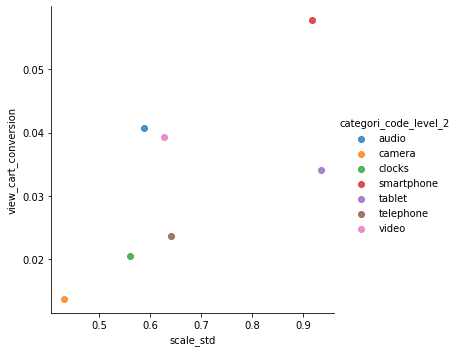

In [38]:
# view_cart conversion은 일단 분석에서 제외하자 -> 매출과 크게 상관없는 데이터
# A군 : 가격의 표준편차가 낮고, 카트에는 담는 제품군 -> audio, video 
# B군 : 가격의 표준편차가 낮고, 카트에 물건을 담지 않는 제품군 -> camera, clock, telephone -> 고민을 하지 않는다. -> 실제 cart_purchase conversion도 가장 높은 군
# C군 : 가격의 표준편차가 크고, 카트에 물건을 담는 제품군 -> tablet -> 가격 대비 실용성의 고민?
# D군 : 가격의 표준편차가 크고, 카트에 물건을 담지 않는 제품군 -> smartphone -> 압도적인 브랜드 파워(apple)

scatter = sns.lmplot(x='scale_std', y='view_cart_conversion', hue = 'categori_code_level_2', data=df_elec_sta_cart)

In [39]:
# 전자제품의 가격 편차와 view-cart conversion 간의 상관계수
# scale_std = std / mean -> 평균 대비 표준편차의 크기(변동계수)

X = df_elec_sta_cart.scale_std
Y = df_elec_sta_cart.view_cart_conversion
np.corrcoef(X, Y)[0, 1]

0.7042309701477476

In [40]:
df_elec_sta_cart

,categori_code_level_2,event_type,count,mean,std,min,25%,50%,75%,max,scale_std,view_counts,purchase_counts,view_cart_conversion,view_purchase_conversion,cart_purchase_conversion
0,audio,cart,8291.0,117.255574,68.981589,1.00,40.900,159.91,161.840,1214.06,0.588301,203784.0,5078.0,0.040685,0.024919,0.612471
1,camera,cart,86.0,363.785465,157.012747,61.52,205.735,437.41,463.050,898.12,0.431608,6268.0,71.0,0.013720,0.011327,0.825581
2,clocks,cart,3455.0,328.827939,184.584198,0.00,179.900,319.34,444.995,1878.55,0.561340,168047.0,2470.0,0.020560,0.014698,0.714906
3,smartphone,cart,82759.0,432.383919,396.271240,0.00,170.600,250.43,581.160,2110.45,0.916480,1433050.0,45991.0,0.057750,0.032093,0.555722
4,tablet,cart,1387.0,259.712487,242.672976,0.00,110.680,163.46,254.060,1758.32,0.934391,40663.0,809.0,0.034110,0.019895,0.583273
5,telephone,cart,742.0,36.164960,23.185369,6.36,21.040,30.83,49.420,97.51,0.641100,31303.0,487.0,0.023704,0.015558,0.656334
6,video,cart,5820.0,395.967426,248.298234,102.19,256.710,369.37,475.910,2574.04,0.627067,147950.0,3050.0,0.039338,0.020615,0.524055


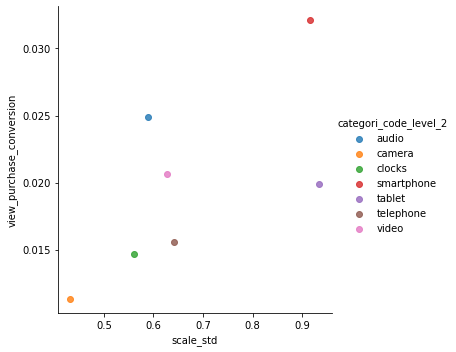

In [43]:
# view_purchase conversion

# A군 : 가격의 표준편차가 낮고, 판매 전환율이 낮은 제품군 -> camera, clocks, telephone -> 대체제가 있는 상품들 -> 효용성에 대한 고민? -> 사야할 이유를 제시해야 함
# B군 : 가격의 표준편차가 낮고, 판매 전환율이 높은 제품군 -> video, audio -> 가전 필수 제품(주로 tv, 이어폰/헤드셋)
# C군 : 가격의 표준편차가 크고, 판매 전환율이 낮은 제품군 -> tablet -> 가격 대비 실용성의 고민? -> 프로모션의 대상
# D군 : 가격의 표준편차가 크고, 판매 전환율이 높은 제품군 -> smartphone


scatter = sns.lmplot(x='scale_std', y='view_purchase_conversion', data=df_elec_sta_cart, hue = 'categori_code_level_2')

In [44]:
X = df_elec_sta_cart.scale_std
Y = df_elec_sta_cart.view_purchase_conversion
np.corrcoef(X, Y)[0, 1]

0.6767427074266062

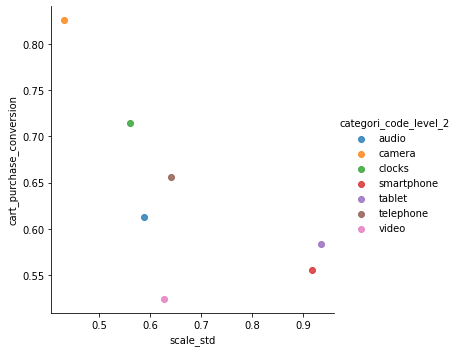

In [45]:
# A군 : 가격의 표준편차가 낮고, 판매 전환율이 낮은 제품군 -> video, audio, telephone -> 카트에 담은 수 대비 구매율이 낮음 -> 고민을 시작하면 잘 구매하지 않는다 -> 구매에 대한 유인 필요
# B군 : 가격의 표준편차가 낮고, 판매 전환율이 높은 제품군 -> camera, clocks -> view-purchase conversion은 낮지만 cart-purchase conversion은 높은 상품들 -> 해당 상품의 필요성에 대해 고민하게 만들면, 즉 카트에 담게 하면 성공
# C군 : 가격의 표준편차가 크고, 판매 전환율이 낮은 제품군 -> tablet, smartphone -> 프로모션의 대상 -> 카트에 담은 제품에 대해서 프로모션, 유사 제품 추천 등을 진행


scatter = sns.lmplot(x='scale_std', y='cart_purchase_conversion',hue = 'categori_code_level_2', data=df_elec_sta_cart)

In [46]:
X = df_elec_sta_cart.scale_std
Y = df_elec_sta_cart.cart_purchase_conversion
np.corrcoef(X, Y)[0, 1]

-0.6997824215312282

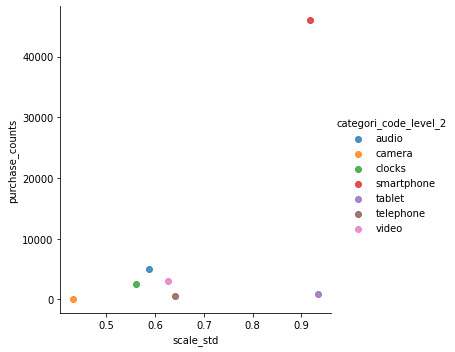

In [47]:
scatter = sns.lmplot(x='scale_std', y='purchase_counts', hue = 'categori_code_level_2', data=df_elec_sta_cart)

In [48]:
X = df_elec_sta_cart.scale_std
Y = df_elec_sta_cart.purchase_counts
np.corrcoef(X, Y)[0, 1]

0.5676618039392276

In [49]:
def make_std_table(df_temp):
    df_sta = df_temp.groupby(['categori_code_level_2', 'event_type']).price.describe().reset_index()
    df_sta['scale_std'] = df_sta['std'] / df_sta['mean']
    df_sta_fin = df_sta.loc[df_sta['event_type'] == 'cart'].reset_index(drop=True)
    df_sta_fin['view_counts'] = df_sta['count'].loc[df_sta['event_type']=='view'].reset_index(drop=True)
    df_sta_fin['purchase_counts'] = df_sta['count'].loc[df_sta['event_type']=='purchase'].reset_index(drop=True)
    df_sta_fin['view_cart_conversion'] = df_sta_fin['count'] / df_sta_fin['view_counts']
    df_sta_fin['view_purchase_conversion'] = df_sta_fin['purchase_counts'] / df_sta_fin['view_counts']
    df_sta_fin['cart_purchase_conversion'] = df_sta_fin['purchase_counts'] / df_sta_fin['count']

    return df_sta_fin

In [57]:
df_appli_sta = make_std_table(df_appli)
df_appli_sta

,categori_code_level_2,event_type,count,mean,std,min,25%,50%,75%,max,scale_std,view_counts,purchase_counts,view_cart_conversion,view_purchase_conversion,cart_purchase_conversion
0,environment,cart,3919.0,130.158671,103.611918,7.31,64.02,102.23,149.2200,965.25,0.796043,151726.0,2585.0,0.025829,0.017037,0.659607
1,iron,cart,602.0,76.224834,98.330688,0.00,20.34,44.38,79.7700,617.75,1.290009,21515.0,547.0,0.027980,0.025424,0.908638
2,ironing_board,cart,60.0,41.404833,27.059741,7.70,14.13,43.73,51.4500,123.53,0.653541,4778.0,100.0,0.012558,0.020929,1.666667
3,kitchen,cart,9306.0,251.924680,197.556504,6.41,89.84,238.28,347.3825,2059.23,0.784189,444739.0,6660.0,0.020925,0.014975,0.715667
4,personal,cart,351.0,28.588091,21.031431,7.70,12.36,23.14,44.8250,124.04,0.735671,18854.0,330.0,0.018617,0.017503,0.940171
5,sewing_machine,cart,353.0,166.949603,206.256370,70.66,92.32,107.82,171.3600,1492.93,1.235441,19537.0,246.0,0.018068,0.012591,0.696884


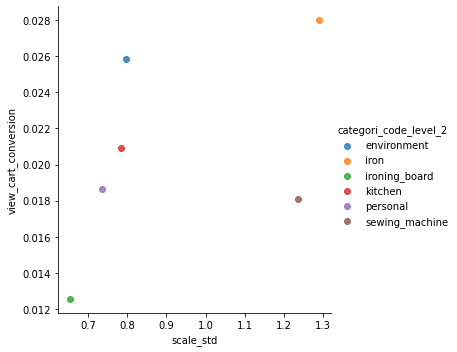

In [58]:
scatter = sns.lmplot(x='scale_std', y='view_cart_conversion', hue = 'categori_code_level_2', data=df_appli_sta)

In [59]:
X = df_appli_sta.scale_std
Y = df_appli_sta.view_cart_conversion
np.corrcoef(X, Y)[0, 1]

0.48879127743936013

In [60]:
df_appli['brand'].loc[df_appli['categori_code_level_2'] == 'personal'].value_counts()

elenberg    2692
philips     2096
xiaomi      1414
braun       1413
scarlett    1344
            ... 
artel          1
beurer         1
medisana       1
kenwood        1
haday          1
Name: brand, Length: 65, dtype: int64

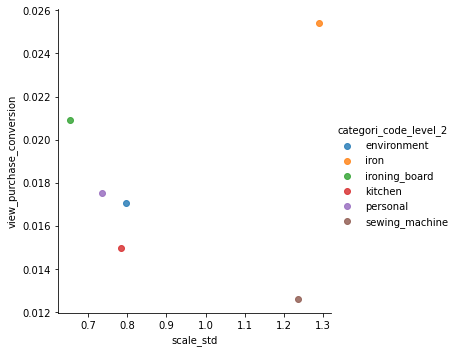

In [62]:
# A집단 : 전환율이 낮고, 가격편차도 낮은 제품군 : environment(청소 용품), kitchen(주방 용품), personal(개인 위생 용품 등) -> 평소 자주 사용하는 용품이지만 구매로 전환되지는 않음
# B집단 : 전환율이 높고, 가격편차가 낮은 제품군 : ironing_board(다리미대) -> view 수는 가장 낮음 -> 정말 필요한 사람만 찾아본다는 뜻(하지만 구매 모수 자체가 많지 않음)
# B집단 : 전환율이 낮고, 가격편차가 큰 제품군 : sewing_machine(재봉틀) -> 쉽게 구매하는 제품이 아님 -> 정말 필요한 사람들만 찾아보지만(낮은 view), 가격편차가 크기 때문에 구매를 망설임 -> 낮은 가격 대의 리뷰가 좋은 제품 추천
# C집단 : 전환율이 높고, 가격편차가 큰 제품군 : iron(다리미 등) -> view는 작지만 가격 편차가 크더라도 필요하다는 생각이 들면 꼭 구매를 하는 제품

scatter = sns.lmplot(x='scale_std', y='view_purchase_conversion', hue = 'categori_code_level_2', data=df_appli_sta)

In [63]:
X = df_appli_sta.scale_std
Y = df_appli_sta.view_purchase_conversion
np.corrcoef(X, Y)[0, 1]

0.1420730156780475

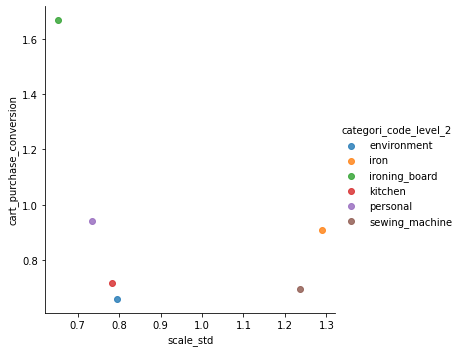

In [64]:
# 전환율이 낮은 집단의 전환율이 거의 1에 가까움
# 기본적으로 cart-purchase 전환율이 굉장히 높은 제품군 -> 필요를 자극하는 하는 방식으로 카트에 담게 하는 방법을 생각해보면 좋을 듯 -> 계획에 의한 소비로 봐도 되지 않을까?

scatter = sns.lmplot(x='scale_std', y='cart_purchase_conversion', hue = 'categori_code_level_2', data=df_appli_sta)

## Computer 가격 변동계수 - Conversion 분석

In [65]:
df_com_sta = make_std_table(df_com)
df_com_sta

,categori_code_level_2,event_type,count,mean,std,min,25%,50%,75%,max,scale_std,view_counts,purchase_counts,view_cart_conversion,view_purchase_conversion,cart_purchase_conversion
0,components,cart,386.0,122.464093,138.692263,11.27,39.2625,66.67,170.6500,1317.25,1.132514,41997.0,544.0,0.009191,0.012953,1.409326
1,desktop,cart,482.0,296.765602,412.547248,5.48,50.4500,121.47,411.8300,2574.04,1.390145,56410.0,413.0,0.008545,0.007321,0.856846
2,ebooks,cart,71.0,140.444789,44.870664,77.08,102.7000,128.45,167.1450,254.81,0.319490,3878.0,50.0,0.018308,0.012893,0.704225
3,notebook,cart,3011.0,574.735918,341.323947,9.24,320.9600,489.05,720.4800,2342.15,0.593880,151203.0,2267.0,0.019914,0.014993,0.752906
4,peripherals,cart,1012.0,164.391374,123.664588,0.00,79.7700,148.04,223.6825,900.90,0.752257,49827.0,712.0,0.020310,0.014289,0.703557


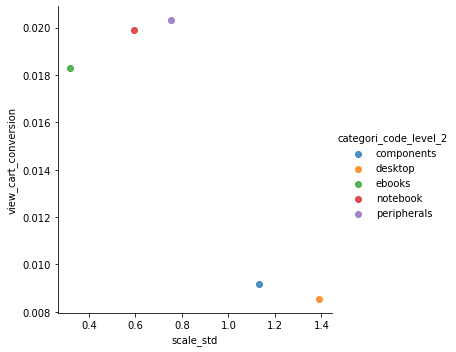

In [66]:
scatter = sns.lmplot(x='scale_std', y='view_cart_conversion', hue = 'categori_code_level_2', data=df_com_sta)

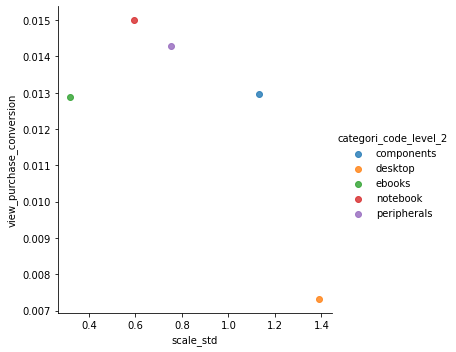

In [67]:
# A군 : 전환율이 낮고, 가격 편차도 작음 : ebook -> 효용성에 대한 고민?(대체제가 많음)
# B군 : 전환율이 높고, 가격 편차가 작음 : notebook, peripherals(주변기기)
# C군 : 전환율이 낮고, 가격 편차가 큼 : components(컴퓨터 부품), desktop -> 제품 간 가격 편차가 커서 가격 비교를 많이 하는 대표적인 제품

scatter = sns.lmplot(x='scale_std', y='view_purchase_conversion', hue = 'categori_code_level_2', data=df_com_sta)

In [ ]:
# A군 : 전환율 낮고, 가격 편차도 작음 : ebook -> 효용성에 대한 고민 -> 리뷰를 노출시키자
# B군 : 가격 차이와 관계 없이 전환율이 거의 1에 가까운 제품군 -> 카트보다 구매 수가 더 많음 -> 카트에 담은 제품에 대해 별도의 프로모션을 진행하지 않아도 됨

scatter = sns.lmplot(x='scale_std', y='cart_purchase_conversion', hue = 'categori_code_level_2', data=df_com_sta)